查看SRNet和SRNet-Modular对深度神经网络的解释效果对比

In [1]:
# see dmlp hidden semantics
import os
import torch
import sympy as sp
from utils import load_pickle
from load_data import load_sr_data
from SRNet import srnets
from neural_network import neural_networks

device = torch.device("cpu")

def load_srnet(path_dir, net, args):
    sr_param = torch.load(os.path.join(path_dir, "sr_param"))
    _, srnet_class = srnets[args.srnet_name]
    srnet = srnet_class(sr_param=sr_param, neural_network=net)
    srnet.load_state_dict(torch.load(os.path.join(path_dir, "srnet"), map_location=device))
    srnet.assign_genes(load_pickle(os.path.join(path_dir, "srnet_genes")))
    return srnet


event_dir = "/Users/lihaoyang/Projects/srn-m/output/compared"
net_dir = "/Users/lihaoyang/Projects/srn-m/output/MLPs"
seeds = [12, 23, 34, 45, 56, 123, 234, 345, 456, 1234]
datasets = [f"kkk{i}" for i in range(6)] + [f"feynman{i}" for i in range(6)]
#  + [f"kkk{i}" for i in range(6)]

for dataset in datasets:
    seed = 23 if dataset == "feynman1" else 12
    srnet_dir = os.path.join(event_dir, f"mlp-{dataset}-{seed}")
    net_path = os.path.join(net_dir, f"MLP-{dataset}", "mlp", "mlp")

    args = torch.load(os.path.join(srnet_dir, "args"))
    train_dataset, _ = load_sr_data(args.dataset)
    n_inputs, n_outputs = train_dataset.X.size(-1), 1

    # load net
    nn_class = neural_networks["MLP"]
    net = nn_class(n_inputs, n_outputs)
    net.load_state_dict(torch.load(net_path))
    net.eval()

    # load sr
    srnet = load_srnet(srnet_dir, net, args)

    exps = [layer.expr(mul_w=False)[0] for layer in srnet.explained_layers]
    for i, expr in enumerate(exps):
        expr = sp.simplify(expr).evalf(4)
        exps[i] = str(expr.xreplace({n : round(n, 2) for n in expr.atoms(sp.Number)})).replace("**", "^")
    hidx = 1
    for i, expr in enumerate(exps[1:]):
        for xidx in range(16):
            if f"x{xidx}" in expr:
                exps[i+1] = exps[i+1].replace(f"x{xidx}", "(hat{h} ^"+f"{hidx})_{xidx}")
        hidx += 1
    print(exps)
    final_expr = srnet.expr()[0]
    final_expr = sp.simplify(final_expr).evalf(4)
    final_expr = str(final_expr.xreplace({n : round(n, 2) for n in final_expr.atoms(sp.Number)})).replace("**", "^")

    print(final_expr)

['0.16 - x', '(hat{h} ^1)_4/Abs((hat{h} ^1)_0)', '(hat{h} ^2)_2*log(Abs((hat{h} ^2)_3))/Abs((hat{h} ^2)_3)']
-0.37*(0.19*(0.25*x + 0.01)/Abs(0.51*x + 0.66) + 0.93)*log(Abs(1.02*(0.25*x + 0.01)/Abs(0.51*x + 0.66) - 0.43))/Abs(1.02*(0.25*x + 0.01)/Abs(0.51*x + 0.66) - 0.43) - 0.52
['cos(x0 - cos(x1))', 'sin((hat{h} ^1)_5)', '-(hat{h} ^2)_2 + (hat{h} ^2)_4']
1.85*sin(1.08*cos(x0 - cos(x1)) - 0.46) - 0.12
['0.58/Abs(x)', '(hat{h} ^1)_1 - (hat{h} ^1)_7 + log(Abs((hat{h} ^1)_5))', 'Abs((hat{h} ^2)_3*((hat{h} ^2)_3 + (hat{h} ^2)_6))']
(0.17*Abs(x)^2 + 0.83*Abs(((0.46*log((0.04*Abs(x) + 0.26)/Abs(x)) - 1.56)*Abs(x) - 0.33)*((0.93*log((0.04*Abs(x) + 0.26)/Abs(x)) - 0.65)*Abs(x) - 0.66)))/Abs(x)^2
['cos(3.0*x1/Abs(x1))', '(hat{h} ^1)_2*(hat{h} ^1)_5', 'Abs((hat{h} ^2)_4 - (hat{h} ^2)_5)^0.5']
0.7*Abs(0.16*cos(3.0*x1/Abs(x1)) + 0.75)^0.5 + 0.86
['log(Abs(cos(sin(x1) + 0.07)))', '(hat{h} ^1)_5/Abs((hat{h} ^1)_5)', 'sin((hat{h} ^2)_6)']
0.31*sin((-0.17*log(Abs(cos(sin(x1) + 0.07))) + 0.08*Abs(0.39*

查看SRNet-Modular解释卷积神经网络的效果

In [1]:
# see conv hidden semantics
import os
import torch
import sympy as sp
from utils import load_pickle
from SRNet import srnets
from SRNet.usr_models import EQLParameter, EQLPDE
from neural_network import neural_networks


device=torch.device("cpu")

class Args:

    n_layers = 5

    def __init__(self, n_layers=5) -> None:
        self.n_layers = n_layers


event_dir = "/Users/lihaoyang/Projects/srn-m/output/find-pde"
net_path = "/Users/lihaoyang/Projects/srn-m/output/LeNet/LeNet"

n_layers=4
layer_idx=0
lr=1e-5
clip_norm=0
pd_weight=1.0
pde_weight=1.0
weight_decay=1e-5
warmup_ratio=0.1

srnet_dir = os.path.join(
    event_dir, 
    f"{n_layers}layers-li{layer_idx}-clip{clip_norm}-lr{lr}-pw{pd_weight}-pew{pde_weight}-wd{weight_decay}-w{warmup_ratio}"
)

# train_dataset, _ = load_mnist_data("./data/img")

# load net
nn_class = neural_networks["LeNet"]
net = nn_class(10)
net.load_state_dict(torch.load(net_path, map_location=device))
net.eval()

args = Args()
# load sr
param = EQLParameter(
    n_inputs=5, # x, y, t, dx?, dy?
    n_outputs=1, # u
    n_eph=0,
    args=args,
    function_set=["add", "mul", "sin", "cos", "square", "log"]
)
PDE = EQLPDE(param, with_fu=False)

expr = PDE.expr(["u_x ", "u_y ", "u_x u_y "], sparse_filter=0.1)  # 这里把偏微分项作为input_vars进行参数输入，但是在表达式EQL的expr()函数，input_vars将放进矩阵进行计算，这里是怎么计算的？

expr = sp.simplify(expr)
expr = str(expr.xreplace({n : round(n, 2) for n in expr.atoms(sp.Number)})).replace("**", "^")
hidx = 1
for xidx in range(16):
    if f"x{xidx}" in expr:
        expr = expr.replace(f"x{xidx}", "(hat{h} ^"+f"{hidx})_{xidx}")

print(expr)  # 根据output/find_pde路径下的PDE.pt，得到图像的偏微分方程

Matrix([[0.04*u_x ^2 - 0.07*u_x *u_x u_y  - 0.07*u_x *u_y  - 0.19*u_x  + 0.08*u_x u_y ^2 + 0.13*u_x u_y *u_y  - 0.18*u_x u_y  + 0.04*u_y ^2 - 0.21*u_y  - 0.12*log(Abs(-0.4*u_x  + 0.23*u_x u_y  + 0.11)) + 0.23*sin(0.39*u_x  + 0.57*u_x u_y  + 0.31*u_y  + 0.14) + 0.28*cos(0.19*u_x  + 0.13*u_y ) - 0.03]])


画SRNet和SRNet-Modular的收敛曲线

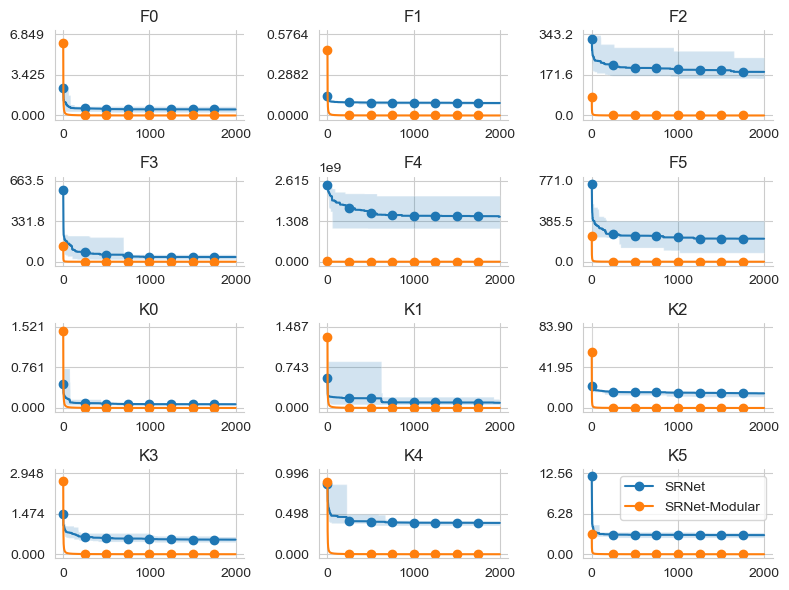

In [3]:
from tensorboard.backend.event_processing import event_accumulator

import glob
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt


def read_tensorboard(path):
    # return cfs: list n_gen
    ea = event_accumulator.EventAccumulator(path)
    ea.Reload()

    train_cfs = ea.scalars.Items("loss/train_epoch_loss")
    val_cfs = ea.scalars.Items("loss/val_loss")

    train_cfs = [x.value for x in train_cfs]
    val_cfs = [x.value for x in val_cfs]
    return train_cfs, val_cfs

ALOT = 1e6


def regression_convergence(result_dir, datasets, all_srnet_convs, all_srnetm_convs, n_row, n_col):
    # convs: n_generations, n_trials

    def fill_convs(convs, max_gen=2000):
        if convs.shape[0] < max_gen:
            fill = np.repeat(convs[-1, :].reshape(1, -1), max_gen-convs.shape[0], axis=0)
            convs = np.vstack((convs, fill))
        return convs

    def get_max_fitness(convs):
        max_fitness = np.max(convs)
        n_gen = 1
        while np.isinf(max_fitness):
            max_fitness = np.max(convs[n_gen:, :])
            n_gen += 1
        return max_fitness

    def draw_range(ax2d, x, convs, label):
        min_conv, max_conv, mean_conv = np.min(convs, axis=1), np.max(convs, axis=1), np.mean(convs, axis=1)
        p1 = ax2d.fill_between(x, min_conv, max_conv, alpha=0.2)
        p2 = ax2d.plot(x, mean_conv, 'o-', markevery=250, label=label)
        ax2d.spines['right'].set_visible(False)
        ax2d.spines['top'].set_visible(False)
        # ax2d.legend([(p1, p2),], [label])
        ax2d.grid()

    i = 1
    fig = plt.figure(figsize=(8, 6))
    for dataset, srnet_convs, srnetm_convs in zip(datasets, all_srnet_convs, all_srnetm_convs):
        ax2d = fig.add_subplot(n_row, n_col, i)
        
        srnet_convs = fill_convs(srnet_convs)
        srnetm_convs = fill_convs(srnetm_convs)
        srnet_max_fitness = get_max_fitness(srnet_convs)
        srnetm_max_fitness = get_max_fitness(srnetm_convs)
        max_fitness = max(srnet_max_fitness, srnetm_max_fitness)

        n_generations = srnet_convs.shape[0]
        x = list(range(n_generations))
        draw_range(ax2d, x, srnet_convs, "SRNet")
        draw_range(ax2d, x, srnetm_convs, "SRNet-Modular")
        ax2d.set_yticks([max_fitness, max_fitness / 2, 0])
        # if i >= 10:
        ax2d.set_xticks([0, 1000, 2000])
        ax2d.set_title(dataset.upper()[0] + dataset[-1])
        i += 1

    plt.legend()
    plt.tight_layout()
    # plt.savefig(os.path.join(result_dir, 'regression_convergence.pdf'), dpi=600)
    plt.show()
    plt.close()


event_dir = "/Users/lihaoyang/Projects/srn-m/output/compared"
seeds = [12, 23, 34, 45, 56, 123, 234, 345, 456, 1234]
datasets = [f"feynman{i}" for i in range(6)] + [f"kkk{i}" for i in range(6)]
n_row, n_col = 4, 3

all_srnet_cfs = []
all_srnetm_cfs = []
for dataset in datasets:
    one_dataset_srnet_cfs = np.loadtxt(
        os.path.join(event_dir, "dmlp", f"{dataset}_30cfs")
    )

    one_dataset_srnetm_cfs = []
    for seed in seeds:
        # print(f"{dataset}-{seed}")
        files = glob.glob(os.path.join(event_dir, fr"mlp-{dataset}-{seed}/tb/**/events**"), recursive=True)
        file = sorted(files)[-1]
        cfs, _ = read_tensorboard(file)
        one_dataset_srnetm_cfs.append(cfs)
    one_dataset_srnetm_cfs = np.stack(one_dataset_srnetm_cfs, axis=1)

    all_srnet_cfs.append(one_dataset_srnet_cfs)
    all_srnetm_cfs.append(one_dataset_srnetm_cfs)

regression_convergence(".", datasets, all_srnet_cfs, all_srnetm_cfs, n_row, n_col)


画SRNet和SRNet-Modular的盒图

0.125 0.7126086956521739 0.2279411764705882 0.16739130434782612
set x label none
0.3985294117647059 0.7126086956521739 0.2279411764705882 0.16739130434782612
set y label none
set x label none
0.6720588235294118 0.7126086956521739 0.2279411764705882 0.16739130434782612
set y label none
set x label none
0.125 0.5117391304347826 0.2279411764705882 0.16739130434782612
set x label none
0.3985294117647059 0.5117391304347826 0.2279411764705882 0.16739130434782612
set y label none
set x label none
0.6720588235294118 0.5117391304347826 0.2279411764705882 0.16739130434782612
set y label none
set x label none
0.125 0.3108695652173913 0.2279411764705882 0.16739130434782606
set x label none
0.3985294117647059 0.3108695652173913 0.2279411764705882 0.16739130434782606
set y label none
set x label none
0.6720588235294118 0.3108695652173913 0.2279411764705882 0.16739130434782606
set y label none
set x label none
0.125 0.10999999999999999 0.2279411764705882 0.16739130434782612
0.3985294117647059 0.10999

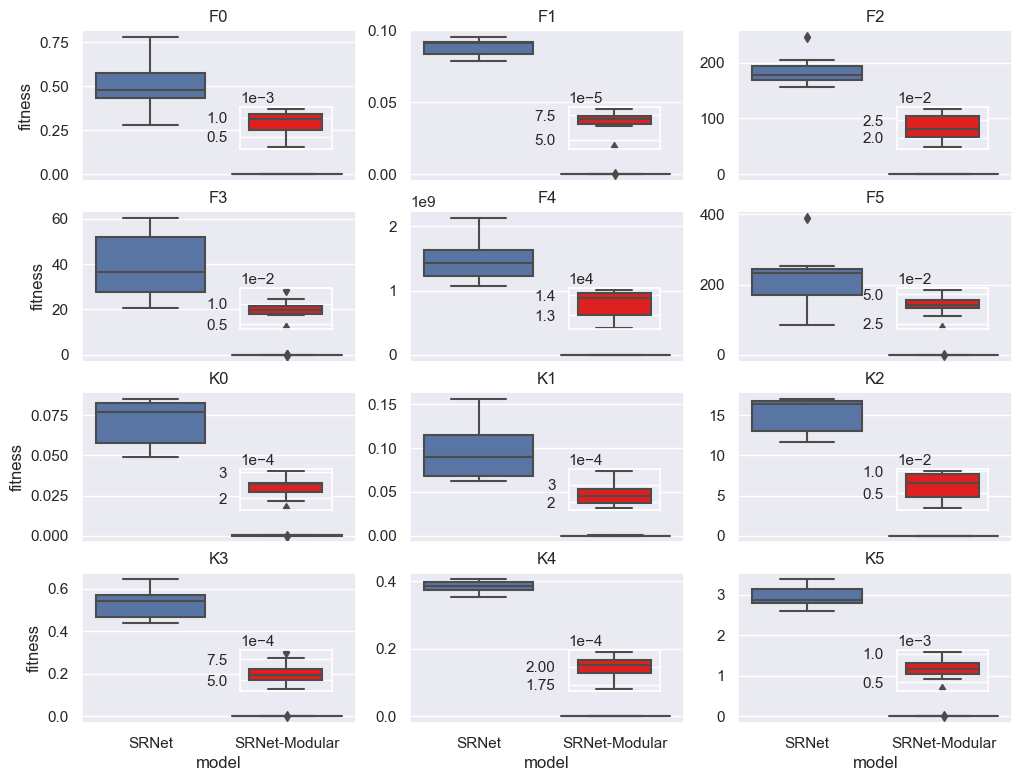

In [4]:
import pandas as pd
sns.set_theme()

def boxplot_convergence(save_file, datasets, all_srnet_convs, all_srnetm_convs, n_row, n_col):
    # convs: (n_generations, n_trials) * len(datasets)

    sub_ax2d_loc = [0.6, 0.6, 0.25, 0.25]
    i = 0
    fig = plt.figure(figsize=(12, 9))
    for dataset, srnet_convs, srnetm_convs in zip(datasets, all_srnet_convs, all_srnetm_convs):
        # srnet_convs: n_gen, n_trials
        ax2d = fig.add_subplot(n_row, n_col, i+1)
        
        srnet_mins = srnet_convs.min(axis=0).flatten().tolist()
        srnetm_mins = srnetm_convs.min(axis=0).flatten().tolist()

        size1, size2 = len(srnet_mins), len(srnetm_mins)
        data = {
            "fitness": srnet_mins + srnetm_mins, 
            "model": ["SRNet"]*size1 + ["SRNet-Modular"]*size2
        }
        df = pd.DataFrame(data, columns=["fitness", "model"] )
        sns.boxplot(x=df["model"], y=df["fitness"], ax=ax2d)
        # sns.boxplot(x=, y=df["fitness"], ax=ax2d)
        
        l, b, w, h = ax2d.get_position().bounds
        print(l, b, w, h)
        sub_ax2d_loc = [l + w - w/3-0.02, b + h / 3-0.02, w/3, h/3-0.01]
        sub_ax2d = fig.add_axes(sub_ax2d_loc)
        sns.boxplot(x=None, y=srnetm_mins, ax=sub_ax2d, color="red")
        sub_ax2d.ticklabel_format(style="sci", axis="y", scilimits=(0, 1))
        ax2d.set_title(dataset.upper()[0] + dataset[-1])

        if i % n_col > 0:
            ax2d.set_ylabel("")
            print("set y label none")
        if i // n_col < n_row - 1:
            ax2d.set_xlabel("")
            ax2d.set_xticklabels("")
            print("set x label none")
        i += 1

    # plt.savefig(save_file, dpi=600)
    plt.show()
    plt.close()

save_file = 'boxplot_convergence.pdf'

# boxplot_convergence(
#     "feynman_"+save_file, 
#     datasets[:6], all_srnet_cfs[:6], all_srnetm_cfs[:6], 
#     3, 2
# )

# boxplot_convergence(
#     "kkk_"+save_file, 
#     datasets[6:], all_srnet_cfs[6:], all_srnetm_cfs[6:], 
#     3, 2
# )

boxplot_convergence(
    save_file, 
    datasets, all_srnet_cfs, all_srnetm_cfs, 
    n_row, n_col
)